In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Read in data
data = pd.read_csv('data/parsed_data.csv').fillna('')
data['tags'] = data['tags'].apply(ast.literal_eval)

In [3]:
# Basic statistics
num_questions = data.shape[0]
tag_counts = data.explode('tags')['tags'].value_counts()

print(f'Number of questions: {num_questions}')
print(f'Number of unique (sufficiently large) tags: {len(tag_counts[tag_counts > 9000])}')

Number of questions: 235312
Number of unique (sufficiently large) tags: 30


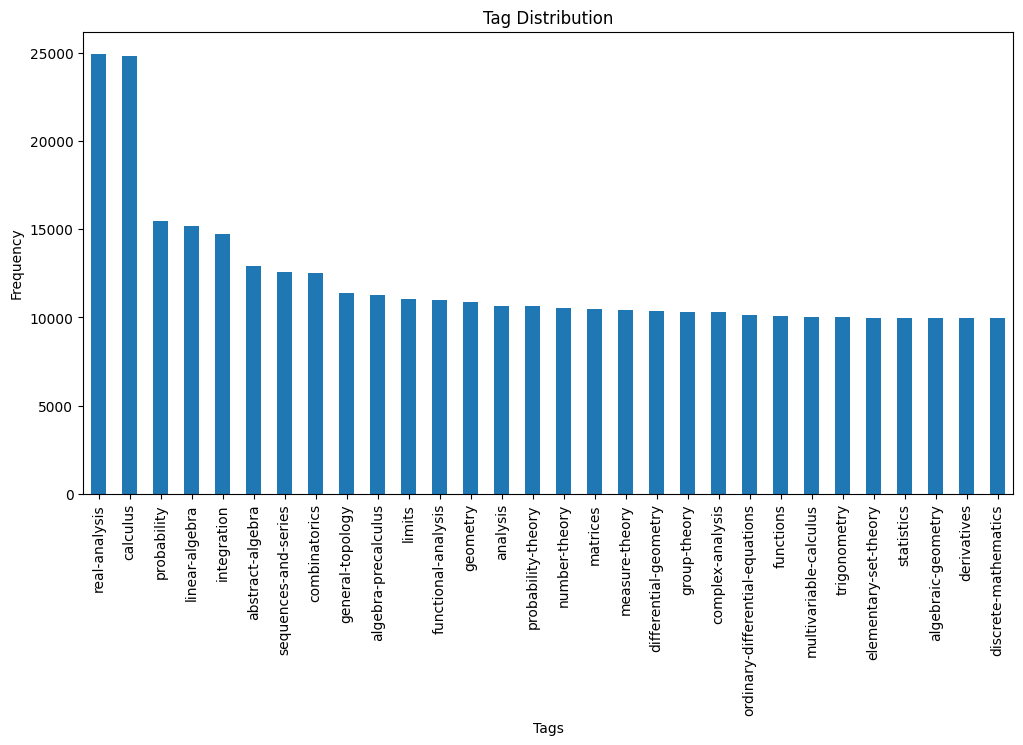

In [4]:
# Distribution of tags
plt.figure(figsize=(12,6))
tag_counts.head(30).plot(kind='bar')
plt.title('Tag Distribution')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.savefig('figs/exploratory_analysis/tag_distribution.png', bbox_inches='tight')
plt.show()

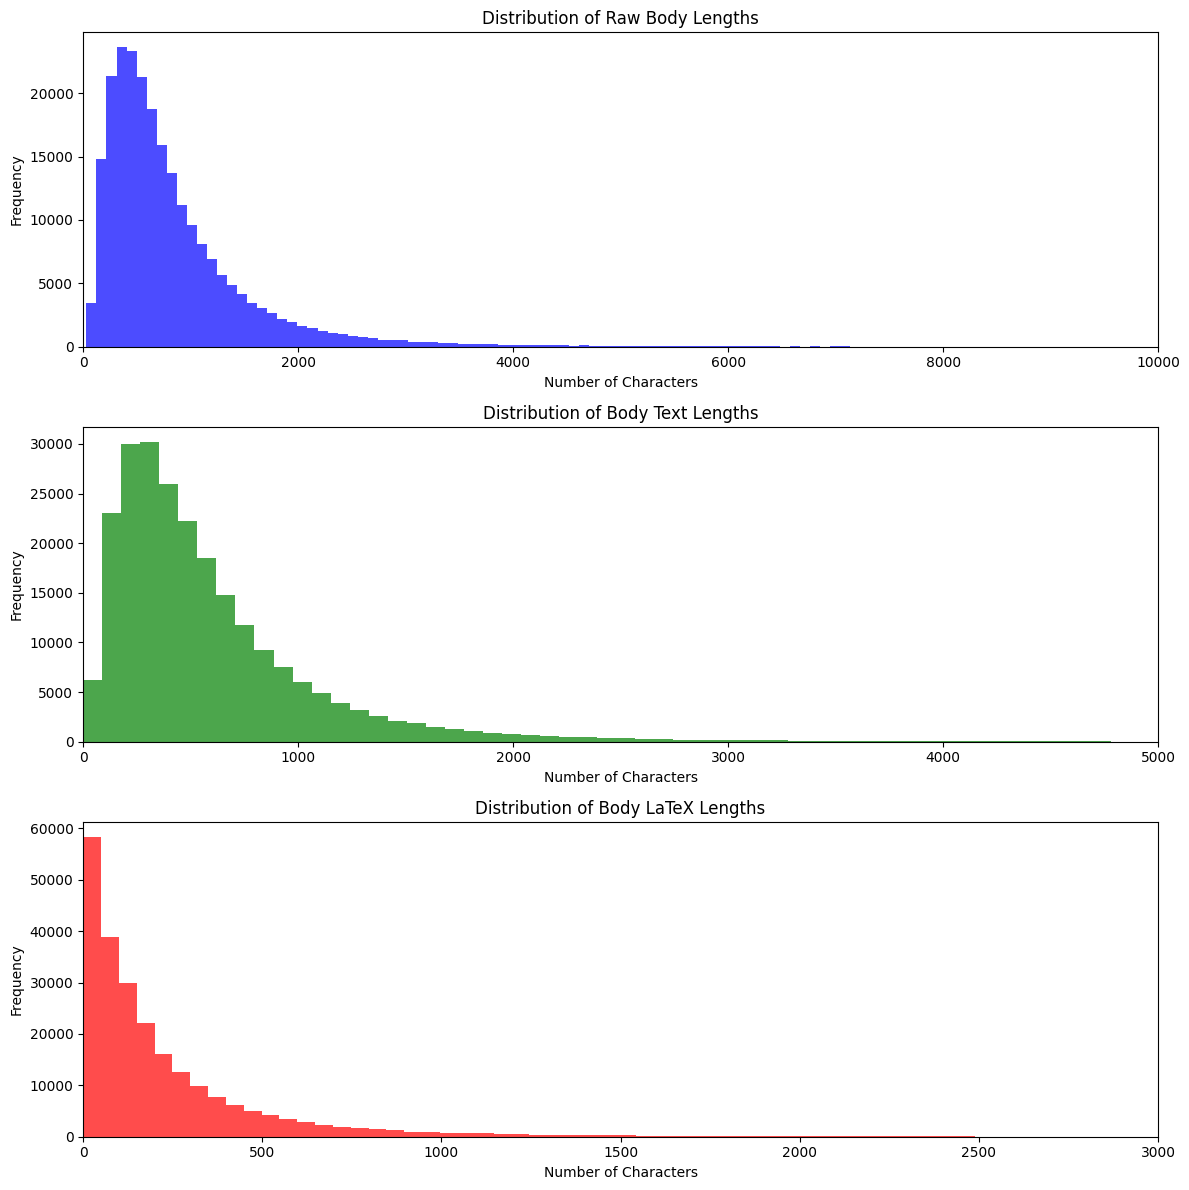

In [5]:
# Text length analysis
data['body_length'] = data['body'].apply(lambda x: len(x))
data['body_text_length'] = data['body_text'].apply(lambda x: len(x))
data['body_latex_length'] = data['body_latex'].apply(lambda x: len(x))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

axes[0].hist(data['body_length'], bins=300, alpha=0.7, color='blue')
axes[0].set_title('Distribution of Raw Body Lengths')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 10000)

axes[1].hist(data['body_text_length'], bins=300, alpha=0.7, color='green')
axes[1].set_title('Distribution of Body Text Lengths')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 5000)

axes[2].hist(data['body_latex_length'], bins=300, alpha=0.7, color='red')
axes[2].set_title('Distribution of Body LaTeX Lengths')
axes[2].set_xlabel('Number of Characters')
axes[2].set_ylabel('Frequency')
axes[2].set_xlim(0, 3000)

plt.tight_layout()
plt.savefig('figs/exploratory_analysis/length_distributions.png', bbox_inches='tight')
plt.show()


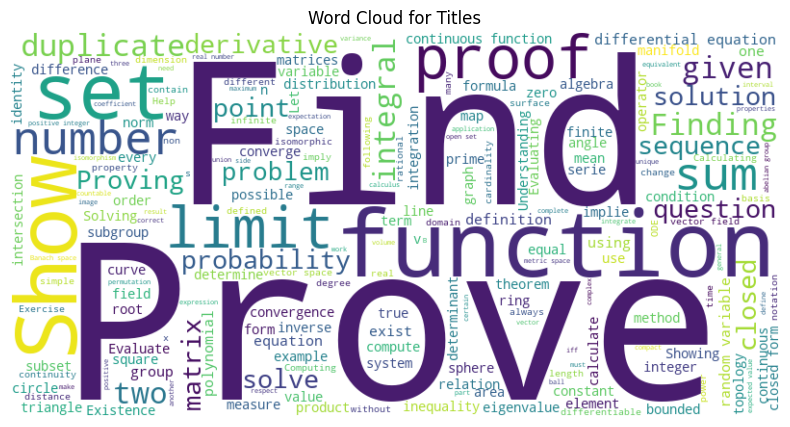

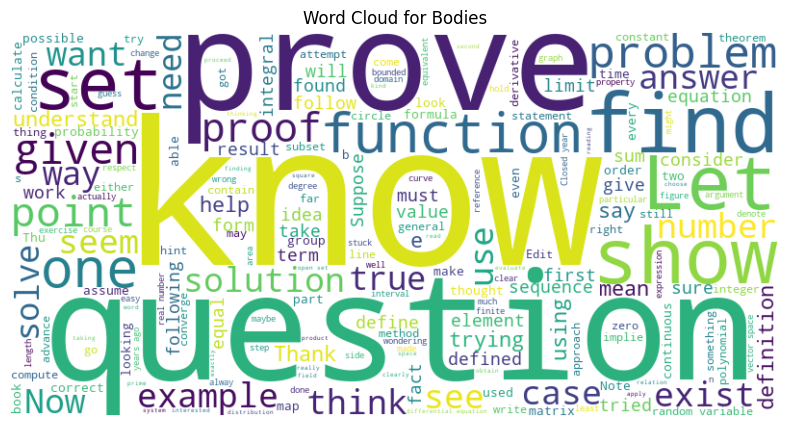

In [6]:
# Wordcloud
title_text = ' '.join(data['title_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Titles')
plt.axis('off')
plt.savefig('figs/exploratory_analysis/title_wordcloud.png', bbox_inches='tight')
plt.show()

# Word cloud for body text
body_text = ' '.join(data['body_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(body_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Bodies')
plt.axis('off')
plt.savefig('figs/exploratory_analysis/body_wordcloud.png', bbox_inches='tight')
plt.show()

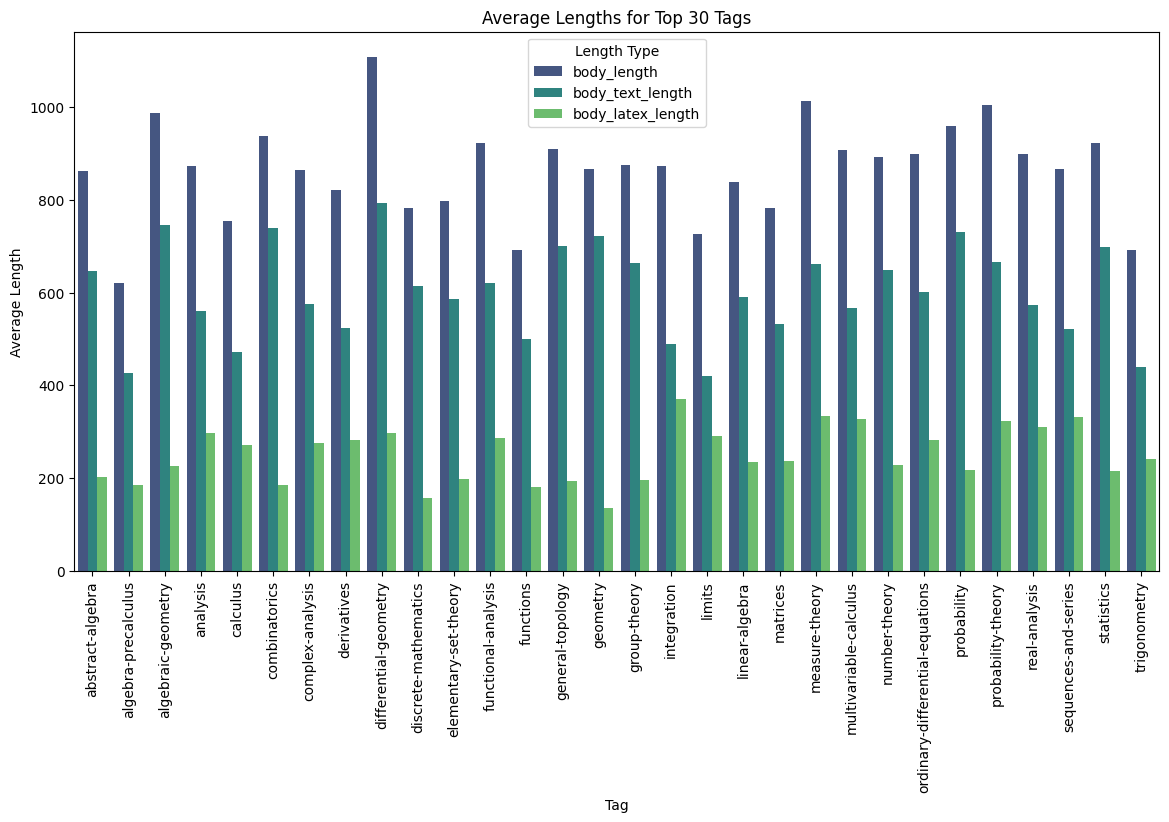

In [7]:
# Length by tag
exploded_data = data.explode('tags')
group_by = exploded_data[exploded_data.tags.isin(tag_counts.head(30).index)].groupby('tags')[[
    'body_length', 'body_text_length', 'body_latex_length']].mean().reset_index()

melted_group_by = pd.melt(group_by, id_vars='tags', value_vars=['body_length', 'body_text_length', 'body_latex_length'],
                          var_name='Length Type', value_name='Average Length')

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x='tags', y='Average Length', hue='Length Type', data=melted_group_by, palette='viridis')
plt.title('Average Lengths for Top 30 Tags')
plt.xlabel('Tag')
plt.ylabel('Average Length')
plt.xticks(rotation=90)
plt.legend(title='Length Type')
plt.savefig('figs/exploratory_analysis/lengths_by_tag.png', bbox_inches='tight')
plt.show()

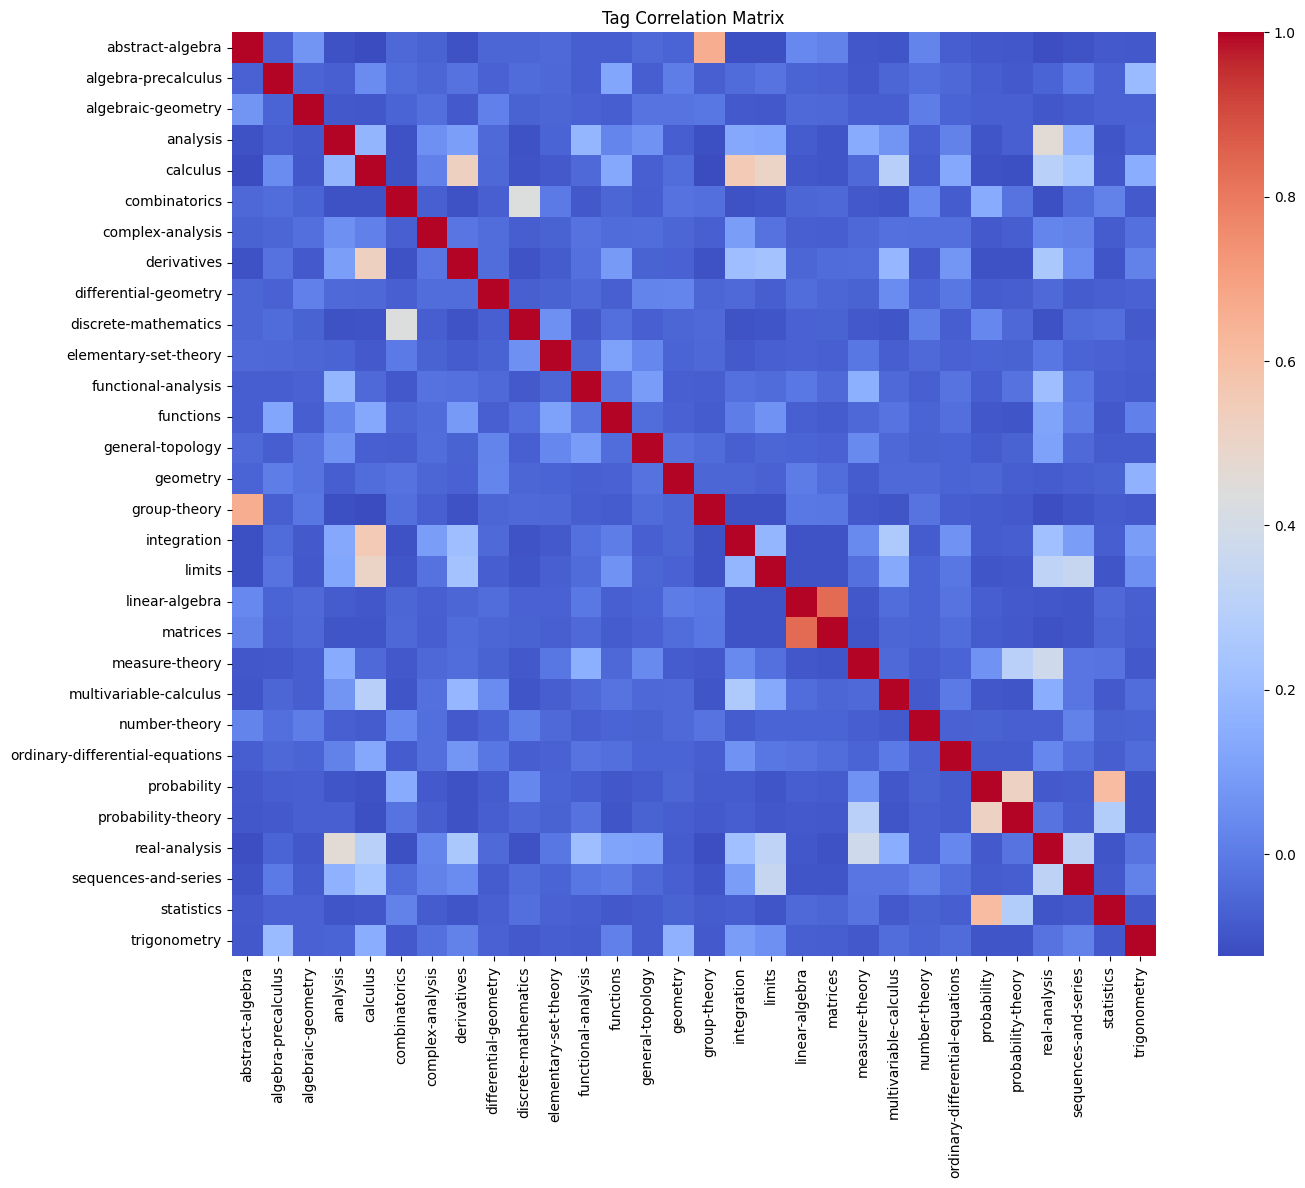

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# Filter out all not top 30 tags
data['tags_clean'] = data['tags'].apply(lambda x: [tag for tag in x if tag in tag_counts.head(30).index])

# Use MultiLabelBinarizer to create a binary matrix for tags
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(data['tags_clean'])

# Create a DataFrame from the binary matrix
tag_df = pd.DataFrame(tag_matrix, columns=mlb.classes_)

# Compute the co-occurrence matrix
co_occurrence_matrix = tag_df.T.dot(tag_df)

# Normalize the co-occurrence matrix
co_occurrence_matrix = co_occurrence_matrix / co_occurrence_matrix.max().max()

# Calculate the correlation matrix
correlation_matrix = co_occurrence_matrix.corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True)
plt.title('Tag Correlation Matrix')
plt.savefig('figs/exploratory_analysis/tag_corr_mat.png', bbox_inches='tight')
plt.show()